In [1]:
import pandas as pd
import geopandas as gpd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import time
import warnings
warnings.filterwarnings("ignore")

# smc: soil_moisture: device_id, soil_mc, soil_ec
smc = pd.read_csv ('soil_moisture_data/2023_ru_soil_moisture.csv')

# create date column
smc['time'] = pd.to_datetime(smc['time'])  
smc['date'] = smc['time'].dt.date
smc['date'] = pd.to_datetime(smc['date'])

# filter data 
condition = (smc['date'] >= '2023-08-09') & (smc['date'] <= '2023-08-20') 
smc = smc.loc[condition]
smc = smc.groupby('device_id')[['soil_mc','soil_ec']].mean()

smc = smc.round({'soil_mc':1, 'soil_ec':1})

smc.head()

,soil_mc,soil_ec
device_id,,
ru-lse-01,29.7,308.8
ru-lse-02,26.2,80.5
ru-lse-03,25.7,109.4
ru-lse-04,26.0,119.5
ru-lse-05,20.7,470.2


In [2]:
# yield_potato: device_id, yield
yield_potato = pd.read_csv('yield/kassow_potato_yield_2023.csv')
yield_potato = yield_potato.drop(columns=['tubers','plants'])
yield_potato = yield_potato.rename(columns={'yield_kg':'yield'})
yield_potato.head()

,device_id,yield,variety
0,ru-lse-05,2.46,HAP
1,ru-lse-06,1.58,HAP
2,ru-lse-07,3.48,HAP
3,ru-lse-08,3.40,HAP
4,ru-lse-09,2.18,HAP


In [3]:
# fc: device_id, FC, PWP
fc = pd.read_csv ('soil_properties_data/2023_ru_sensors_fc_pwp.csv')
fc = fc.rename(columns={'FC [vol-%]':'FC', 'PWP [vol-%]':'PWP'})
fc['AW'] = fc['FC']-fc['PWP']

fc

,device_id,FC,PWP,AW
0,ru-lse-01,37.46,12.59,24.87
1,ru-lse-02,31.10,8.01,23.09
2,ru-lse-03,33.29,9.50,23.79
3,ru-lse-04,30.85,8.00,22.85
4,ru-lse-05,31.42,8.21,23.21
5,ru-lse-06,32.02,8.62,23.40
6,ru-lse-07,34.65,10.50,24.15
7,ru-lse-08,31.00,8.00,23.00
8,ru-lse-09,37.91,13.11,24.80
9,ru-lse-10,32.13,8.49,23.64


In [6]:
# yield_potato: device_id, yield
irrigated = pd.read_csv('soil_moisture_data/2023_kassow_irrigated.csv')
print(irrigated)

    device_id  irrigated_mm
0   ru-lse-05            30
1   ru-lse-06            60
2   ru-lse-07            60
3   ru-lse-08            60
4   ru-lse-09            60
5   ru-lse-10            60
6   ru-lse-11             0
7   ru-lse-12            60
8   ru-lse-13            60
9   ru-lse-14            30
10  ru-lse-15            30
11  ru-lse-16             0
12  ru-lse-17             0
13  ru-lse-18             0
14  ru-lse-19            10
15  ru-lse-20             0
16  ru-lse-21             0
17  ru-lse-22            30
18  ru-lse-23             0
19  ru-lse-24             0
20  ru-lse-25            30
21  ru-lse-26            30
22  ru-lse-27            30
23  ru-lse-28            30
24  ru-lse-29            30
25  ru-lse-30            60


In [5]:
# sensor_loc: device_id, geometry
sensor_loc_gdf = gpd.read_file('soil_moisture_data/ru_sensor_locations.geojson')
sensor_loc_gdf = (sensor_loc_gdf.loc[~sensor_loc_gdf['device_id'].isin(['ru-lse-01','ru-lse-02','ru-lse-03','ru-lse-04'])])

old_crs = sensor_loc_gdf.crs.to_epsg()
sensor_loc_gdf = sensor_loc_gdf.to_crs(5650)
new_crs = sensor_loc_gdf.crs.to_epsg()

#sensor_loc_gdf.plot()


In [6]:
#soil_scanning_gdf: TOC, MC, Clay, TWI, NDVI, pH, P, K, Mg, CEC, NDVI, NDRE, MZ_irr, MZ_fer, fertility
#3630 rows
soil_scanning_gdf = gpd.read_file('soil_properties_data/soil_scanning_kassow.geojson')
old_crs = soil_scanning_gdf.crs.to_epsg()
soil_scanning_gdf = soil_scanning_gdf.to_crs(5650)
new_crs = soil_scanning_gdf.crs.to_epsg()
print("Transform crs of soil_scanning_kassow.geojson from",old_crs,"to",new_crs)

soil_scanning_gdf['MZ_irr'] = soil_scanning_gdf['MZ_irr'].astype("string")
soil_scanning_gdf['MZ_fer'] = soil_scanning_gdf['MZ_fer'].astype("string")

soil_scanning_gdf.head()

Transform crs of soil_scanning_kassow.geojson from 32633 to 5650


,TOC,MC,Clay,TWI,pH,P,K,Mg,CEC,NDVI_S2_22,NDVI_S2_23,NDVI_UAV_23,NDRE_UAV_23,MZ_irr,MZ_fer,fertility,geometry
0,1.02,8.45,8.94,8.91,6.71,15.49,14.51,14.61,9.23,0.49,0.247749,0.332385,0.185871,4,2,H,POINT (33307709.081 5972820.644)
1,1.06,8.19,8.88,8.89,6.70,16.00,14.72,14.51,9.35,0.47,0.197589,0.455102,0.240561,4,2,H,POINT (33307714.063 5972820.221)
2,1.07,8.45,8.64,9.04,6.72,16.09,13.75,14.12,9.95,0.46,0.197589,0.302123,0.175448,4,2,H,POINT (33307719.045 5972819.799)
3,1.09,8.15,8.87,8.59,6.70,16.06,14.64,14.59,9.36,0.47,0.247749,0.392780,0.232225,4,2,H,POINT (33307703.676 5972816.084)
4,1.08,8.16,8.79,8.62,6.69,16.04,14.74,14.68,9.24,0.46,0.247749,0.349937,0.212110,4,2,H,POINT (33307708.658 5972815.662)


In [29]:
lab_data_gdf = gpd.read_file('soil_properties_data/kassow_lab_data_2022.geojson')
#lab_data_gdf.plot('TOC')


lab_data_gdf[['P','K','Mg','Ca','TOC','CEC','pH','MC','Clay']].describe().round(1)
#lab_data_gdf.head()

,P,K,Mg,Ca,TOC,CEC,pH,MC,Clay
count,86.0,85.0,85.0,82.0,85.0,82.0,86.0,86.0,28.0
mean,14.2,15.5,14.5,157.8,1.0,9.5,6.7,8.7,8.3
std,4.8,3.5,3.5,65.1,0.1,3.4,0.4,1.0,2.5
min,8.0,9.0,9.0,87.0,0.7,5.4,5.7,6.9,2.0
25%,10.2,13.0,12.0,124.0,0.9,7.7,6.5,8.0,7.1
50%,13.5,15.0,14.0,136.0,1.0,8.4,6.6,8.7,8.7
75%,16.8,19.0,16.0,168.0,1.1,10.4,6.9,9.3,9.7
max,29.0,23.0,32.0,400.0,1.6,21.9,7.7,11.4,14.1


In [7]:
# Join everything to the locations of the soil moisture sensors
# ss_sensor: TOC, MC, Clay, TWI, NDVI, pH, P, K, Mg, CEC, MZ_irr, MZ_fer, fertility, NDVI_23
ss_sensor_gdf = gpd.sjoin_nearest(sensor_loc_gdf, soil_scanning_gdf)

ss_sensor = pd.DataFrame(ss_sensor_gdf)
ss_sensor = pd.DataFrame(ss_sensor.drop(columns=['index_right','geometry']))

#ss_sensor_gdf.plot(column="P", cmap='winter',legend="TRUE")
ss_sensor.head()

,device_id,TOC,MC,Clay,TWI,pH,P,K,Mg,CEC,NDVI_S2_22,NDVI_S2_23,NDVI_UAV_23,NDRE_UAV_23,MZ_irr,MZ_fer,fertility
4,ru-lse-05,1.06,8.75,8.70,7.29,6.47,13.37,14.32,13.28,9.05,0.45,0.311084,0.878740,0.403959,2,1,ML
5,ru-lse-06,0.98,8.22,9.17,6.97,6.57,11.21,15.37,13.86,9.31,0.43,0.433928,0.912813,0.446259,3,4,L
6,ru-lse-07,0.96,8.85,9.23,8.12,6.64,10.61,15.82,13.77,8.93,0.44,0.463660,0.898499,0.399137,1,4,L
7,ru-lse-08,1.01,8.39,8.80,9.91,6.51,12.13,15.02,13.25,8.68,0.42,0.514008,0.914488,0.427558,4,1,ML
8,ru-lse-09,0.99,9.05,9.29,6.29,6.74,10.94,17.20,13.75,8.49,0.43,0.473025,0.911743,0.436818,1,4,L


In [8]:
# Nmin P K MC pH SOC Mg Texture Temp date geometry
# Nmin:kg/ha P:mg/100g K mg/100g Mg mg/100g
# 537 rows
stenon_gdf = gpd.read_file('soil_properties_data/stenon_kassow.geojson')
old_crs = stenon_gdf.crs.to_epsg()
stenon_gdf = stenon_gdf.to_crs(5650)
new_crs = stenon_gdf.crs.to_epsg()
print("Transform crs of stenon_kassow.geojson from",old_crs,"to",new_crs)
stenon_gdf.head()

Transform crs of stenon_kassow.geojson from 4326 to 5650


,Nmin,P,K,MC,pH,SOC,Mg,Texture,date,geometry
0,83,9.4,10.1,11.1,6.5,1.1,8.1,2,2022-11-09,POINT (33307686.021 5972779.024)
1,55,7.9,9.7,11.7,6.4,0.9,7.4,2,2022-11-09,POINT (33307718.586 5972735.425)
2,53,6.2,11.0,12.2,6.5,1.0,7.0,2,2022-11-09,POINT (33307754.574 5972698.659)
3,63,9.7,12.5,11.2,6.6,1.1,7.8,2,2022-11-09,POINT (33307792.524 5972667.003)
4,58,8.1,9.0,11.1,6.3,0.9,7.2,2,2022-11-09,POINT (33307822.671 5972624.140)


In [9]:
# Nmin P K MC pH SOC Mg Texture Temp date geometry
# Nmin:kg/ha P:mg/100g K mg/100g Mg mg/100g
# 527 rows
stenon_z_gdf = gpd.read_file('soil_properties_data/stenon_z_kassow.geojson')
old_crs = stenon_z_gdf.crs.to_epsg()
stenon_z_gdf = stenon_z_gdf.to_crs(5650)
new_crs = stenon_z_gdf.crs.to_epsg()
print("Transform crs of stenon_z_kassow.geojson from",old_crs,"to",new_crs)
stenon_z_gdf.head()

Transform crs of stenon_z_kassow.geojson from 4326 to 5650


,Nmin,P,K,MC,pH,SOC,Mg,Texture,date,geometry
0,1.81,2.02,-0.06,-0.13,0.54,1.24,1.06,2,2022-11-09,POINT (33307686.021 5972779.024)
1,-0.53,0.34,-0.35,0.42,-0.16,-0.43,0.56,2,2022-11-09,POINT (33307718.586 5972735.425)
2,-0.70,-1.55,0.59,0.88,0.54,0.41,0.27,2,2022-11-09,POINT (33307754.574 5972698.659)
3,0.14,2.36,1.67,-0.03,1.23,1.24,0.84,2,2022-11-09,POINT (33307792.524 5972667.003)
4,-0.28,0.57,-0.85,-0.13,-0.86,-0.43,0.41,2,2022-11-09,POINT (33307822.671 5972624.140)


In [10]:
gdf = sensor_loc_gdf.merge(yield_potato, on='device_id', how='left')
sensor_loc_gdf.head()

,device_id,geometry
4,ru-lse-05,POINT (33307673.287 5972771.985)
5,ru-lse-06,POINT (33307690.653 5972740.633)
6,ru-lse-07,POINT (33307701.150 5972748.332)
7,ru-lse-08,POINT (33307735.296 5972715.764)
8,ru-lse-09,POINT (33307777.818 5972675.542)


In [11]:
gdf = sensor_loc_gdf.merge(yield_potato, on='device_id', how='left')
gdf = gdf.merge(fc, on='device_id', how='left')
gdf = gdf.merge(smc, on='device_id', how='left')
gdf = gdf.merge(irrigated, on='device_id', how='left')

gdf = gdf.round({'AW':1})
gdf = gdf.merge(ss_sensor, on='device_id', how='left')

#df = df.merge(fc, on='device_id', how='left')

gdf.to_file('output_files/sensor_dataframe.geojson', driver="GeoJSON")  

#df = df.merge(MZ, on='MZ_irr', how='left')
#df = df.merge(sensor, on='device_id', how='left')
gdf.head()

,device_id,geometry,yield,variety,FC,PWP,AW,soil_mc,soil_ec,irrigated_mm,...,K,Mg,CEC,NDVI_S2_22,NDVI_S2_23,NDVI_UAV_23,NDRE_UAV_23,MZ_irr,MZ_fer,fertility
0,ru-lse-05,POINT (33307673.287 5972771.985),2.46,HAP,31.42,8.21,23.2,20.7,470.2,30,...,14.32,13.28,9.05,0.45,0.311084,0.878740,0.403959,2,1,ML
1,ru-lse-06,POINT (33307690.653 5972740.633),1.58,HAP,32.02,8.62,23.4,23.7,122.9,60,...,15.37,13.86,9.31,0.43,0.433928,0.912813,0.446259,3,4,L
2,ru-lse-07,POINT (33307701.150 5972748.332),3.48,HAP,34.65,10.50,24.2,23.9,105.1,60,...,15.82,13.77,8.93,0.44,0.463660,0.898499,0.399137,1,4,L
3,ru-lse-08,POINT (33307735.296 5972715.764),3.40,HAP,31.00,8.00,23.0,25.7,90.2,60,...,15.02,13.25,8.68,0.42,0.514008,0.914488,0.427558,4,1,ML
4,ru-lse-09,POINT (33307777.818 5972675.542),2.18,HAP,37.91,13.11,24.8,24.7,211.0,60,...,17.20,13.75,8.49,0.43,0.473025,0.911743,0.436818,1,4,L


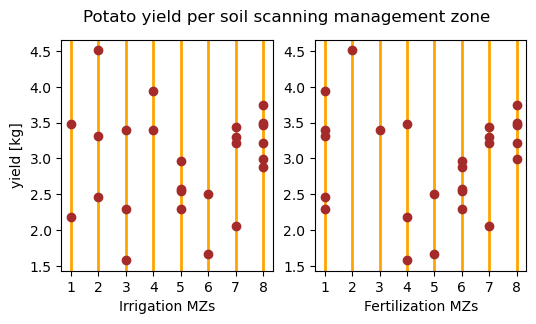

In [12]:
plt.rcParams["figure.figsize"] = (6,3)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Potato yield per soil scanning management zone')

gdf = gdf.sort_values(by=['MZ_irr'])
ax1.scatter(gdf['MZ_irr'], gdf['yield'], color='brown')
gdf = gdf.sort_values(by=['MZ_fer'])
ax2.scatter(gdf['MZ_fer'], gdf['yield'], color='brown')
ax1.set_ylabel('yield [kg]')
ax1.set_xlabel('Irrigation MZs')
ax2.set_xlabel('Fertilization MZs')
#ax1.set_xticks(['1','2','3','4','5','6','7','8'], ['1.1','1.2','1.3','1.4','3.1','3.2','3.3','3.4'])
#ax2.set_xticks(['1','3','4','5','6','7','8'], ['1.1','1.3','1.4','3.1','3.2','3.3','3.4'])
ax1.grid(visible=True, axis='x', color='orange', lw=2)
ax2.grid(visible=True, axis='x', color='orange', lw=2)
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)
plt.savefig('plots/yield_per_soil_scanning_MZ.png', bbox_inches='tight', dpi=400)


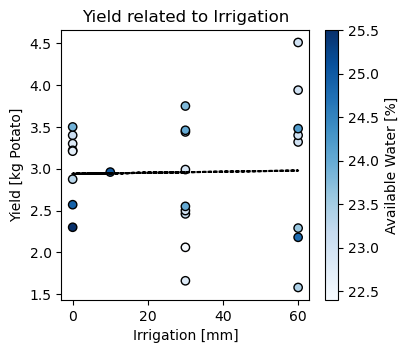

In [14]:
plt.rcParams["figure.figsize"] = (4, 3.5)

x = gdf['irrigated_mm']
y = gdf['yield']
color_column = gdf['AW']

coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef) 

plt.scatter(x, y, c=color_column, cmap='Blues',edgecolors="black")
plt.plot(x, poly1d_fn(x), ':k')

plt.title('Yield related to Irrigation')
plt.xlabel('Irrigation [mm]')
plt.ylabel('Yield [kg Potato]')

# Add colorbar for reference
cbar = plt.colorbar()
cbar.set_label('Available Water [%]')

plt.savefig('plots/yield_per_irrigation_mm.png', bbox_inches='tight', dpi=400)


In [16]:
variety_yield = gdf.groupby('variety')['yield'].mean().round(1)
variety_yield

variety
Albatros     3.0
Euroflora    4.5
Euroresa     2.8
HAP          2.9
Name: yield, dtype: float64

In [17]:
irrigation_yield = gdf.groupby('irrigated_mm')['yield'].mean().round(2)
irrigation_yield

irrigated_mm
0     3.05
10    2.96
30    2.76
60    3.09
Name: yield, dtype: float64

In [18]:
irrigation_variety_yield = gdf.groupby(['irrigated_mm','variety'])['yield'].mean().round(1)
irrigation_variety_yield

irrigated_mm  variety  
0             Albatros     3.0
              Euroresa     2.9
              HAP          3.4
10            Albatros     3.0
30            Albatros     2.8
              Euroresa     2.8
              HAP          2.5
60            Euroflora    4.5
              HAP          2.9
Name: yield, dtype: float64

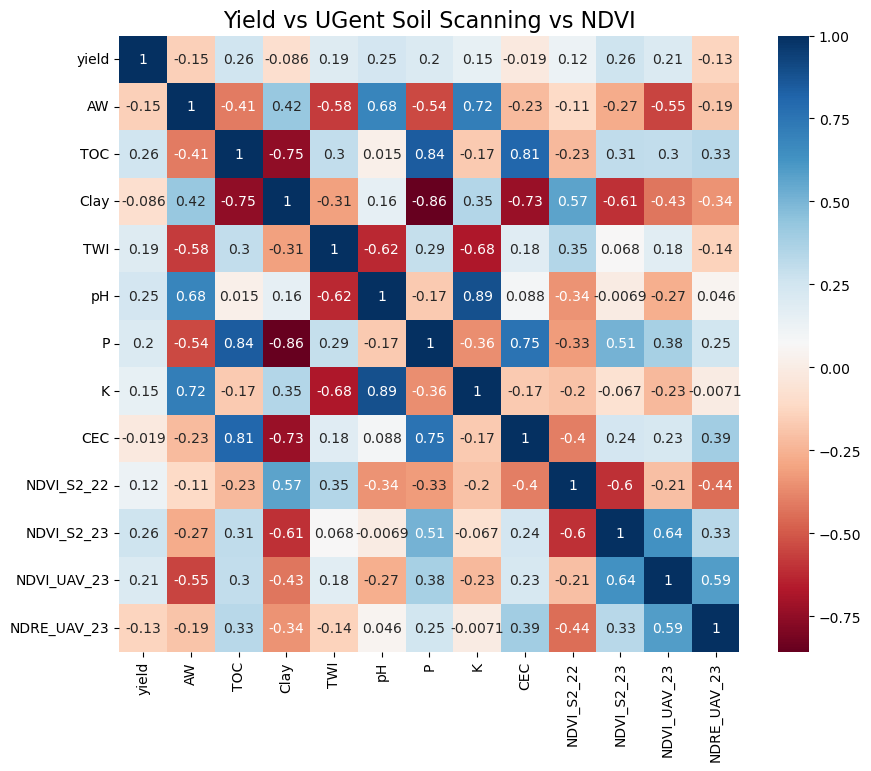

In [22]:
# Yield to AW for each sensor
import seaborn as sn

plt.rcParams["figure.figsize"] = (10,(8))

params = ['yield','AW','TOC','Clay','TWI','pH','P','K','CEC','NDVI_S2_22','NDVI_S2_23', 'NDVI_UAV_23', 'NDRE_UAV_23']

#kassow_25_sensor = kassow_25[params].groupby('device_id').mean()
#kassow_25_sensor

corr_matrix = gdf[params].corr()
sn.heatmap(corr_matrix, annot=True, cmap="RdBu")
plt.title('Yield vs UGent Soil Scanning vs NDVI', size=16)

plt.savefig('plots/corr_matrix_soil_scanning.png', bbox_inches='tight', dpi=400)


In [159]:

#plt.scatter(kassow_25_sensor['P'], kassow_25_sensor['Clay'])

In [160]:
stenon_z_ss_gdf = stenon_z_gdf
stenon_z_ss_gdf = stenon_z_ss_gdf.rename(columns={'Nmin':'Nmin_Stenon','P':'P_Stenon','K':'K_Stenon','MC':'MC_Stenon','pH':'pH_Stenon','SOC':'SOC_Stenon','Mg':'Mg_Stenon','Texture':'Texture_Stenon'})
stenon_z_ss_gdf = gpd.sjoin_nearest(stenon_z_ss_gdf, soil_scanning_gdf)
stenon_z_ss_gdf.head()

,Nmin_Stenon,P_Stenon,K_Stenon,MC_Stenon,pH_Stenon,SOC_Stenon,Mg_Stenon,Texture_Stenon,date,geometry,...,K,Mg,CEC,NDVI_S2_22,NDVI_S2_23,NDVI_UAV_23,NDRE_UAV_23,MZ_irr,MZ_fer,fertility
0,1.81,2.02,-0.06,-0.13,0.54,1.24,1.06,2,2022-11-09,POINT (33307686.021 5972779.024),...,15.41,14.16,9.07,0.43,0.342091,0.377425,0.221562,2,4,L
1,-0.53,0.34,-0.35,0.42,-0.16,-0.43,0.56,2,2022-11-09,POINT (33307718.586 5972735.425),...,14.21,13.49,8.72,0.43,0.491261,0.909117,0.404775,4,1,ML
2,-0.70,-1.55,0.59,0.88,0.54,0.41,0.27,2,2022-11-09,POINT (33307754.574 5972698.659),...,15.70,13.15,8.85,0.43,0.487938,0.906159,0.425127,3,4,L
3,0.14,2.36,1.67,-0.03,1.23,1.24,0.84,2,2022-11-09,POINT (33307792.524 5972667.003),...,15.45,13.51,9.16,0.43,0.451439,0.916509,0.442676,1,4,L
4,-0.28,0.57,-0.85,-0.13,-0.86,-0.43,0.41,2,2022-11-09,POINT (33307822.671 5972624.140),...,14.53,12.96,8.74,0.42,0.524414,0.907898,0.424522,4,1,ML


In [161]:
stenon_ss_gdf = stenon_gdf
stenon_ss_gdf = stenon_ss_gdf.rename(columns={'Nmin':'Nmin_Stenon','P':'P_Stenon','K':'K_Stenon','MC':'MC_Stenon','pH':'pH_Stenon','SOC':'SOC_Stenon','Mg':'Mg_Stenon','Texture':'Texture_Stenon'})
stenon_ss_gdf = gpd.sjoin_nearest(stenon_ss_gdf, soil_scanning_gdf)
stenon_ss_gdf.head()

,Nmin_Stenon,P_Stenon,K_Stenon,MC_Stenon,pH_Stenon,SOC_Stenon,Mg_Stenon,Texture_Stenon,date,geometry,...,K,Mg,CEC,NDVI_S2_22,NDVI_S2_23,NDVI_UAV_23,NDRE_UAV_23,MZ_irr,MZ_fer,fertility
0,83,9.4,10.1,11.1,6.5,1.1,8.1,2,2022-11-09,POINT (33307686.021 5972779.024),...,15.41,14.16,9.07,0.43,0.342091,0.377425,0.221562,2,4,L
1,55,7.9,9.7,11.7,6.4,0.9,7.4,2,2022-11-09,POINT (33307718.586 5972735.425),...,14.21,13.49,8.72,0.43,0.491261,0.909117,0.404775,4,1,ML
2,53,6.2,11.0,12.2,6.5,1.0,7.0,2,2022-11-09,POINT (33307754.574 5972698.659),...,15.70,13.15,8.85,0.43,0.487938,0.906159,0.425127,3,4,L
3,63,9.7,12.5,11.2,6.6,1.1,7.8,2,2022-11-09,POINT (33307792.524 5972667.003),...,15.45,13.51,9.16,0.43,0.451439,0.916509,0.442676,1,4,L
4,58,8.1,9.0,11.1,6.3,0.9,7.2,2,2022-11-09,POINT (33307822.671 5972624.140),...,14.53,12.96,8.74,0.42,0.524414,0.907898,0.424522,4,1,ML


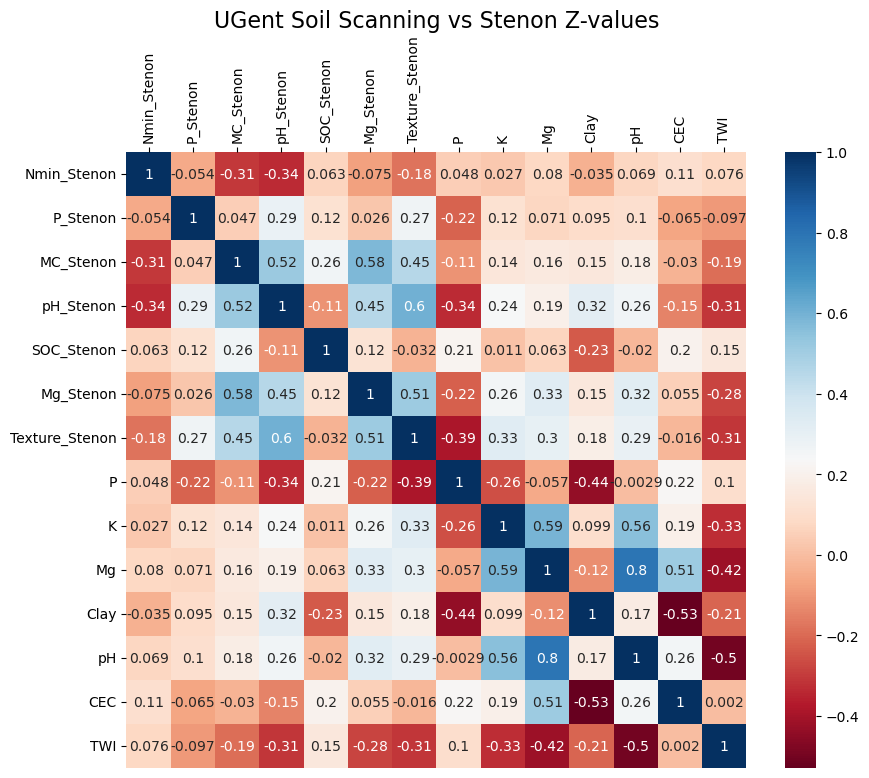

In [180]:
import seaborn as sn

plt.rcParams["figure.figsize"] = (10,(8))

params = ['Nmin_Stenon','P_Stenon','MC_Stenon','pH_Stenon','SOC_Stenon','Mg_Stenon','Texture_Stenon','P','K','Mg','Clay','pH','CEC','TWI']

#kassow_25_sensor = kassow_25[params].groupby('device_id').mean()
#kassow_25_sensor

corr_matrix = stenon_z_ss_gdf[params].corr()
ax = sn.heatmap(corr_matrix, annot=True, cmap="RdBu")
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title('UGent Soil Scanning vs Stenon Z-values', size=16)

plt.savefig('plots/corr_matrix_stenonZ_vs_soil_scanning.png', bbox_inches='tight', dpi=400)

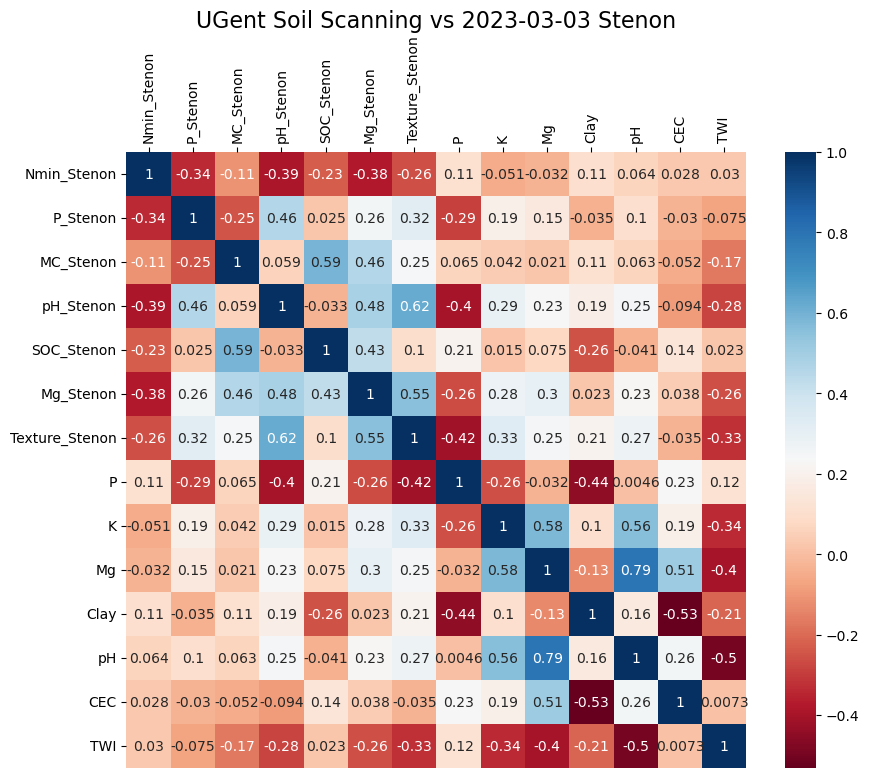

In [181]:
plt.rcParams["figure.figsize"] = (10,(8))
stenon_corr = stenon_ss_gdf.loc[stenon_ss_gdf['date'] == '2023-03-03']
params = ['Nmin_Stenon','P_Stenon','MC_Stenon','pH_Stenon','SOC_Stenon','Mg_Stenon','Texture_Stenon','P','K','Mg','Clay','pH','CEC','TWI']
corr_matrix = stenon_ss_gdf[params].corr()

#sn.heatmap(corr_matrix, annot=True)
ax = sn.heatmap(corr_matrix, annot=True, cmap="RdBu")
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title('UGent Soil Scanning vs 2023-03-03 Stenon', size=16)
plt.savefig('plots/corr_matrix_stenon_2023-03-03_vs_soil_scanning.png', bbox_inches='tight', dpi=400)

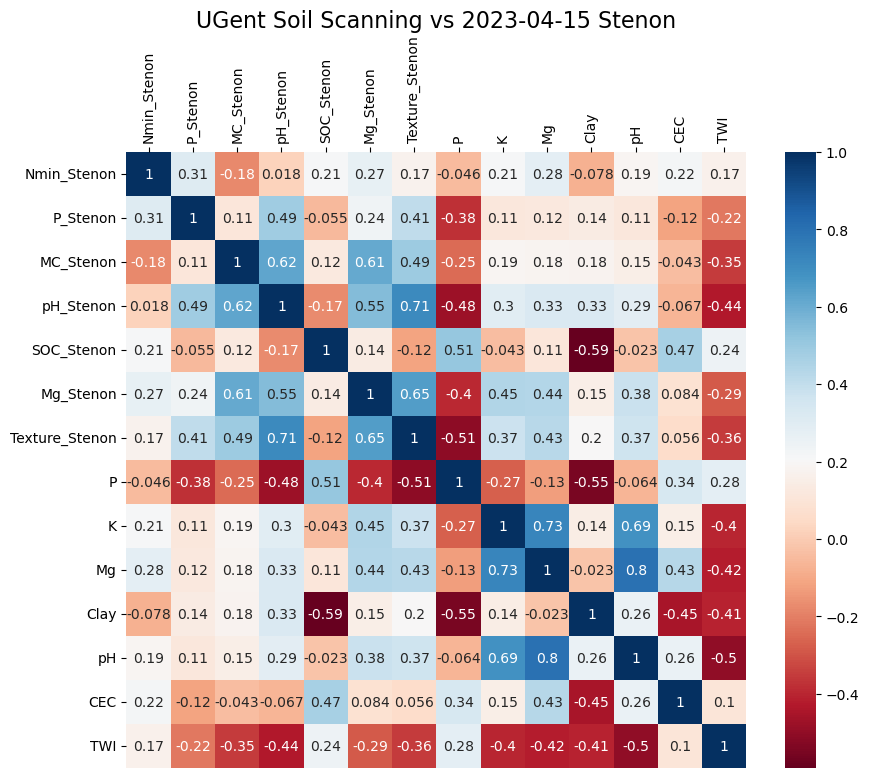

In [182]:
plt.rcParams["figure.figsize"] = (10,(8))
stenon_corr = stenon_ss_gdf.loc[stenon_ss_gdf['date'] == '2023-04-15']
params = ['Nmin_Stenon','P_Stenon','MC_Stenon','pH_Stenon','SOC_Stenon','Mg_Stenon','Texture_Stenon','P','K','Mg','Clay','pH','CEC','TWI']

corr_matrix = stenon_corr[params].corr()
#sn.heatmap(corr_matrix, annot=True)
ax = sn.heatmap(corr_matrix, annot=True, cmap="RdBu")
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title('UGent Soil Scanning vs 2023-04-15 Stenon', size=16)
plt.savefig('plots/corr_matrix_stenon_2023-04-15_vs_soil_scanning.png', bbox_inches='tight', dpi=400)

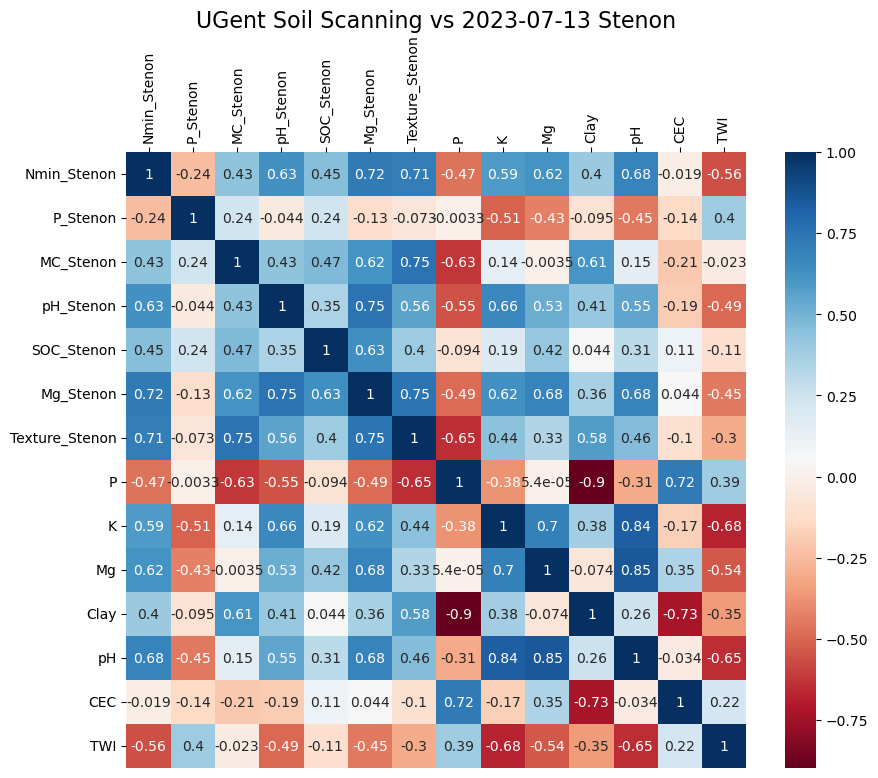

In [183]:
plt.rcParams["figure.figsize"] = (10,(8))
stenon_corr = stenon_ss_gdf.loc[stenon_ss_gdf['date'] == '2023-07-13']
params = ['Nmin_Stenon','P_Stenon','MC_Stenon','pH_Stenon','SOC_Stenon','Mg_Stenon','Texture_Stenon','P','K','Mg','Clay','pH','CEC','TWI']

corr_matrix = stenon_corr[params].corr()
#sn.heatmap(corr_matrix, annot=True)
ax = sn.heatmap(corr_matrix, annot=True, cmap="RdBu")
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title('UGent Soil Scanning vs 2023-07-13 Stenon', size=16)
plt.savefig('plots/corr_matrix_stenon_2023-07-13_vs_soil_scanning.png', bbox_inches='tight', dpi=400)

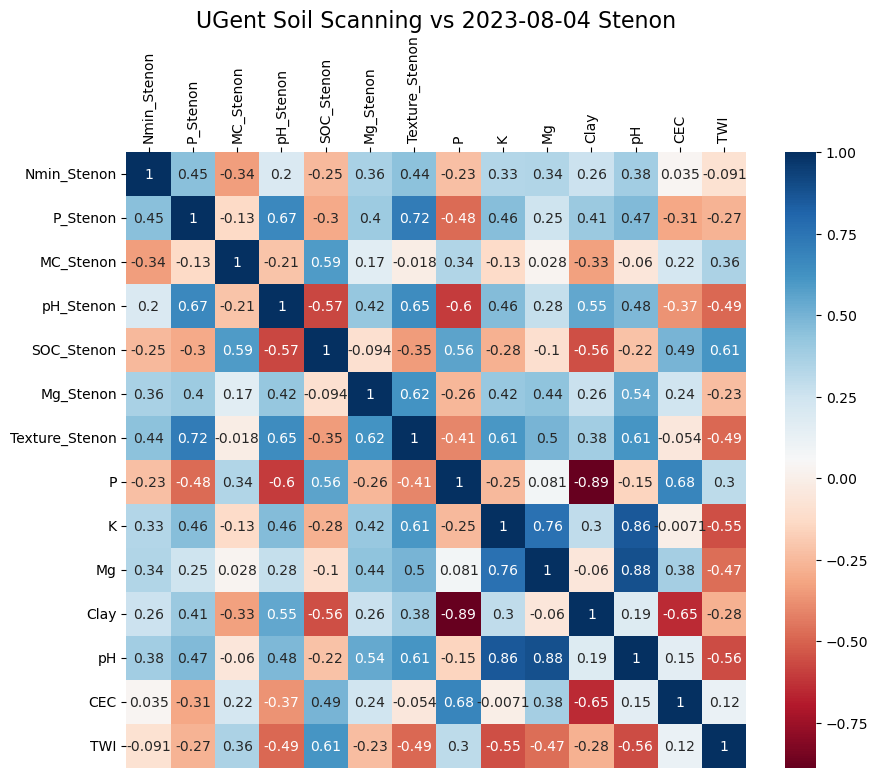

In [184]:
plt.rcParams["figure.figsize"] = (10,(8))
stenon_corr = stenon_ss_gdf.loc[stenon_ss_gdf['date'] == '2023-08-04']
params = ['Nmin_Stenon','P_Stenon','MC_Stenon','pH_Stenon','SOC_Stenon','Mg_Stenon','Texture_Stenon','P','K','Mg','Clay','pH','CEC','TWI']

corr_matrix = stenon_corr[params].corr()
#sn.heatmap(corr_matrix, annot=True)
ax = sn.heatmap(corr_matrix, annot=True, cmap="RdBu")
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title('UGent Soil Scanning vs 2023-08-04 Stenon', size=16)
plt.savefig('plots/corr_matrix_stenon_2023-08-04_vs_soil_scanning.png', bbox_inches='tight', dpi=400)